In [56]:
! pip install langchain_core


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


# Workflows vs Agents
- Workflow: Pre-define the pipeline including LLM
- Agent: Only has two blocks, llm and tool. LLM will receive feedback from tool and decide what to do next
  - When to use: Task is not easily captured in a workflow, open-ended task

In [73]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [74]:
# LLM
import os
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-3-5-sonnet-latest", base_url=os.environ['ANTHROPIC_BASE_URL'])

In [ ]:
# Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )
    # answer: str = Field(None, description="Brief answer to this query, backed with at least 2 examples" )

# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output.search_query)
print(output.justification)

In [6]:
llm.invoke("How does Calcium CT score relate to high cholesterol?")

AIMessage(content="Calcium CT score and high cholesterol are related but distinct markers of cardiovascular health:\n\nKey relationships:\n1. Both are risk factors for cardiovascular disease\n2. High cholesterol can contribute to calcium buildup in arteries\n3. LDL cholesterol particularly plays a role in arterial calcification\n\nHowever:\n- High cholesterol doesn't always mean a high calcium score\n- A person can have a high calcium score with normal cholesterol\n- Calcium score indicates existing plaque buildup\n- Cholesterol levels indicate current risk factors\n\nThe calcium score is more of a direct measure of atherosclerosis (plaque buildup), while cholesterol is a risk factor that can contribute to plaque formation over time. High cholesterol levels over many years can lead to increased calcium deposits in arteries, potentially resulting in a higher calcium score.\n\nManaging both through:\n- Healthy diet\n- Regular exercise\n- Medication (if prescribed)\n- Regular monitoring\n

In [8]:
output.answer

'Calcium CT score (coronary calcium score) and high cholesterol are related as they both indicate cardiovascular risk. High cholesterol, particularly LDL, contributes to calcium buildup in arterial walls. Examples: 1) The MESA study showed patients with higher LDL cholesterol tend to have higher calcium scores 2) The Heinz Nixdorf Recall study demonstrated that elevated cholesterol levels were associated with increased coronary calcification progression.'

In [61]:
# Define a tool
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    '''Multiply a and b'''
    return a * b

@tool
def plus(a: int, b: int) -> int:
    '''Add a and b'''
    return a + b

In [11]:
# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply, plus])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
print(msg.tool_calls)

[{'name': 'plus', 'args': {'a': 2, 'b': 3}, 'id': 'toolu_018nCVmcLisziaSy5pLGWdoM', 'type': 'tool_call'}]


In [13]:
msg.content

[{'text': "I'll help you add 2 and 3 using the plus function.",
  'type': 'text'},
 {'id': 'toolu_018nCVmcLisziaSy5pLGWdoM',
  'input': {'a': 2, 'b': 3},
  'name': 'plus',
  'type': 'tool_use'}]

# Basic Prompt Chaining

In [32]:
from typing_extensions import TypedDict

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

class Joke(BaseModel):
    has_punchline: bool = Field(None, description="Does this joke has any punchline?")

In [36]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}, but do not use any punchline")
    return {"joke": msg.content}

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

# Conditional edge function to check if the joke has a punchline
def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    has_punchline = llm.with_structured_output(Joke).invoke(state["joke"]).has_punchline

    # Simple check - does the joke contain "?" or "!"
    if has_punchline:
        return "Pass"
    return "Fail"

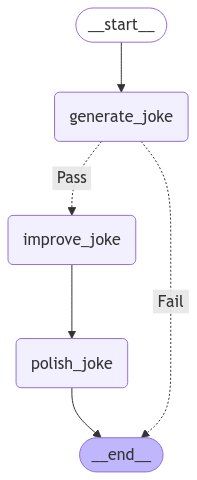

In [37]:

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Pass": "improve_joke", "Fail": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [38]:
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why did the cat refuse to help its friend move apartments?

Because cats are inherently selfish creatures who don't care about your plans, and this one was perfectly comfortable right where it was, thank you very much.

(More of an observation than a punchline, really!)

--- --- ---

Joke failed quality gate - no punchline detected!


# Orchestrator-Worker
How this is different from Paralellization: LLM will define the steps for themselves

In [39]:
from typing import Annotated, List
import operator

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [41]:
# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

- Each section spawned from the planner will be assigned a worker state
- State and WorkerState both share completed_sections. Updates from WorkerState will overwrite the value 

In [42]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.constants import Send



# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section."),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

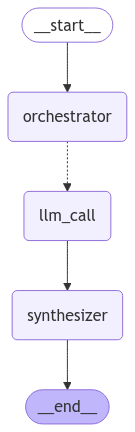

In [45]:
orchestrator_worker_builder = StateGraph(State)

orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges("orchestrator", assign_workers, {"llm_call": "llm_call"})
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

orchestrator_worker = orchestrator_worker_builder.compile()

display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [46]:
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})
from IPython.display import Markdown

Markdown(state["final_report"])

Here's a draft report section on LLM Scaling Laws:

Introduction to LLM Scaling Laws

Scaling laws represent one of the most important empirical discoveries in modern artificial intelligence, particularly in the development of Large Language Models (LLMs). These laws describe mathematical relationships between model performance and key variables such as model size, dataset size, and computational resources. Understanding these relationships has become crucial for advancing AI capabilities and making informed decisions about model development.

At their core, scaling laws reveal that model performance improves in predictable ways as we increase various inputs. The most significant scaling relationships occur across three primary dimensions:

1. Model size (number of parameters)
2. Training dataset size
3. Compute budget

The discovery of these laws emerged through systematic empirical studies, most notably by researchers at OpenAI in 2020. Their seminal paper "Scaling Laws for Neural Language Models" demonstrated that model performance follows surprisingly smooth power-law relationships with these key variables. This finding transformed our understanding of how to build better AI systems and challenged previous assumptions about diminishing returns in model scaling.

Historical Context

Prior to the identification of scaling laws, AI researchers largely worked through trial and error to determine optimal model architectures and sizes. The field lacked clear principles for understanding how increased investment in model size or training data would translate to improved performance. The emergence of scaling laws provided a quantitative framework for making these decisions and helped explain why larger models consistently outperformed smaller ones when properly trained.

Importance in AI Development

Scaling laws have become fundamental to modern AI development for several reasons:

1. Strategic Planning: They enable organizations to make informed decisions about resource allocation and model development strategies.

2. Performance Prediction: They allow researchers to forecast the potential capabilities of larger models before building them.

3. Economic Understanding: They help quantify the relationship between investment (in compute and data) and expected returns in model performance.

4. Technical Insights: They reveal fundamental properties about how neural networks learn and scale, contributing to our theoretical understanding of deep learning.

The practical implications of scaling laws have been profound. They helped motivate the development of increasingly large models like GPT-3, PaLM, and GPT-4, while also providing a framework for understanding the tradeoffs involved in model scaling decisions. Organizations can use these laws to make strategic choices about whether to invest in larger models, more training data, or increased compute resources.

Understanding scaling laws is essential for anyone working in AI development, as they continue to guide the field's trajectory and inform decisions about future AI systems. While recent research has revealed some limitations and nuances to these relationships, the basic principles of scaling laws remain a cornerstone of modern AI development.

This introduction sets the stage for deeper exploration of specific scaling relationships, their mathematical formulation, and practical applications in subsequent sections. The field continues to evolve, with new insights emerging about how these laws apply to different architectures, tasks, and training regimes.

[End of section]

---

Here's a draft report section on Fundamental Scaling Relationships:

# Fundamental Scaling Relationships

The field of artificial intelligence has been transformed by the discovery of consistent scaling laws that govern the behavior of large language models and other AI systems. These mathematical relationships provide crucial insights into how model performance improves with increases in key factors like computation, model size, and dataset size. This section examines the fundamental scaling relationships and their implications for AI development.

## Computation and Model Size Scaling

One of the most important findings from Kaplan et al.'s seminal 2020 paper is that model performance follows a power-law relationship with compute and model size. Specifically:

- Loss (L) scales with compute (C) according to: L ∝ C^(-0.050)
- Loss scales with model parameters (N) as: L ∝ N^(-0.076)

These relationships hold remarkably consistent across different model architectures and sizes, suggesting fundamental laws governing neural network learning. The power-law scaling indicates that each doubling of compute or model size yields a predictable improvement in performance, though with diminishing returns.

## Dataset Scaling

Dataset size also follows clear scaling patterns:
- Models require progressively larger datasets to continue improving as they grow in size
- There exists an optimal dataset size for any given compute budget
- Using too small a dataset leads to overfitting while too large a dataset wastes computation

The empirical relationship found by Kaplan et al. is:
D_optimal ∝ C^(0.74)

where D_optimal is the optimal dataset size and C is the compute budget.

## Optimal Model Shape

Research has also revealed relationships governing optimal model architecture:
- For a given compute budget, there are optimal ratios between:
  - Model depth vs width
  - Context length vs model size
  - Learning rate vs model size
- These relationships help inform efficient model design

## The Chinchilla Scaling Laws

Building on Kaplan's work, the Chinchilla paper (Hoffmann et al., 2022) refined our understanding of scaling relationships by showing that many models were actually undertrained. Their key findings include:

- Optimal compute allocation should be split more evenly between model size and training tokens
- For a fixed compute budget, smaller models trained on more data often outperform larger models trained on less data
- The optimal number of training tokens scales roughly linearly with model parameters

## Practical Implications

These scaling laws have important practical implications:
- They enable accurate prediction of required resources for target performance levels
- They inform efficient allocation of compute between model size and training
- They help identify diminishing returns points
- They guide architecture design decisions

## Limitations and Open Questions

While scaling laws have proven remarkably robust, some limitations and open questions remain:
- Uncertainty about whether scaling patterns continue indefinitely
- Potential existence of phase transitions or fundamental limits
- Applicability to new architectures and training approaches
- Role of data quality vs quantity
- Impact of architectural innovations on scaling behavior

## Future Directions

Active areas of research include:
- Scaling laws for multimodal models
- Impact of sparsity and mixture-of-experts architectures
- Relationship between scaling and emergence of capabilities
- More efficient scaling through architectural innovations
- Dataset scaling properties and optimal data mixing strategies

Understanding these fundamental scaling relationships has been crucial for advancing AI capabilities and will continue to guide research and development efforts. As models continue to grow larger and more sophisticated, these mathematical relationships provide an essential framework for systematic progress in the field.

The insights from scaling laws emphasize that AI progress is not just about building bigger models, but about optimizing the relationship between computation, model architecture, and training data. This understanding has led to more efficient and effective approaches to developing advanced AI systems.

---

Here's a draft of the report section:

Training Compute and Model Size
==============================

The relationship between computational resources and model parameters represents a critical consideration in the development and scaling of large language models. This section examines the interplay between training compute, model size, and performance while analyzing the key trade-offs involved in model scaling decisions.

Scaling Laws and Compute Requirements
-----------------------------------

Research has established clear empirical relationships between model size, training compute, and model performance. These scaling laws generally follow power-law relationships where:

- Model performance improves roughly logarithmically with compute and parameter count
- Training compute requirements grow quadratically with model size
- Optimal model size scales roughly with available compute budget raised to the 0.7-0.8 power

For example, training a 175B parameter model like GPT-3 required approximately 3,640 petaflop-days of compute. Scaling to larger models leads to even more dramatic compute requirements, highlighting the importance of careful resource allocation.

Optimal Model Sizing
-------------------

When determining optimal model size, several key factors must be balanced:

1. Available compute budget
2. Training dataset size
3. Target task requirements
4. Inference costs and deployment constraints

Research suggests that for a given compute budget, there exists an optimal model size that maximizes performance. Models that are too small underfit the training data, while oversized models suffer from inefficient training dynamics and potential instability.

Scaling Dimensions Trade-offs
----------------------------

Three main dimensions can be scaled in language models:

1. Model size (number of parameters)
2. Training compute (FLOPs used during training)
3. Dataset size

Each dimension presents distinct trade-offs:

Model Size vs. Training Compute:
- Larger models require more compute per training step
- Better final performance but slower training
- Higher memory requirements and inference costs

Training Compute vs. Dataset Size:
- More compute allows for more training epochs
- Diminishing returns as compute increases without proportional dataset growth
- Risk of overfitting with excessive computation on limited data

Dataset Size vs. Model Size:
- Larger models require more diverse training data
- Insufficient data can lead to memorization and poor generalization
- Data quality becomes increasingly important as scale increases

Practical Considerations
-----------------------

When making scaling decisions, several practical factors should be considered:

1. Infrastructure Constraints:
- Available GPU/TPU capacity
- Memory limitations
- Network bandwidth
- Storage requirements

2. Economic Factors:
- Training costs
- Inference costs
- Development timeline
- Resource availability

3. Performance Requirements:
- Target accuracy metrics
- Inference latency needs
- Deployment environment constraints

Future Trends and Recommendations
-------------------------------

As the field continues to evolve, several trends and recommendations emerge:

1. Efficient Scaling:
- Focus on architectural improvements that enable better compute utilization
- Explore methods for reducing memory requirements
- Investigate techniques for improving training efficiency

2. Optimal Resource Allocation:
- Balance model size with available compute and data
- Consider staged training approaches
- Leverage pre-training and fine-tuning strategies

3. Cost-Effective Solutions:
- Evaluate performance/cost trade-offs
- Consider smaller, more efficient architectures
- Explore model compression and distillation techniques

Conclusion
----------

The relationship between training compute and model size remains a central consideration in language model development. Success requires careful optimization of resources across multiple dimensions while considering practical constraints and requirements. As the field advances, finding innovative ways to improve efficiency and reduce resource requirements will become increasingly important.

Understanding these relationships and trade-offs enables more informed decisions about model scaling strategies and resource allocation, ultimately leading to more effective and efficient language models.

---

Here's a draft report section on Dataset Scaling and Quality:

Dataset Scaling and Quality

The relationship between dataset size, quality, and large language model (LLM) performance has emerged as a critical area of investigation in the field of artificial intelligence. This section examines the complex interplay between data requirements and model capabilities, highlighting key findings and considerations for optimal LLM development.

Data Scaling Requirements

Research has demonstrated a strong correlation between dataset size and model performance, though this relationship is not strictly linear. Studies indicate that LLM capabilities tend to follow a power-law scaling curve, where performance improvements become increasingly difficult to achieve with additional data beyond certain thresholds. Key observations include:

- Performance scaling appears to follow roughly logarithmic growth with dataset size
- Different tasks show varying sensitivity to data volume
- The benefits of increased data volume may plateau at different points for different capabilities

Quality vs. Quantity Trade-offs

While larger datasets generally enable better performance, the quality of training data has emerged as an equally crucial factor. High-quality data characteristics include:

- Accuracy and factual correctness
- Diversity of topics and writing styles
- Appropriate content filtering
- Consistent formatting and labeling
- Representative coverage of target domains

Research suggests that smaller, carefully curated datasets can sometimes outperform larger but noisier ones, particularly for specialized tasks. However, maintaining both quality and scale remains the ideal approach.

Data Requirements by Model Size

The relationship between model parameters and optimal dataset size appears to follow predictable patterns:

Small models (<1B parameters):
- Can be effectively trained on datasets of 1-10B tokens
- More sensitive to data quality
- May benefit more from task-specific fine-tuning

Large models (>100B parameters):
- Typically require 100B+ tokens for pre-training
- Can better leverage noisy or imperfect data
- Show improved few-shot learning capabilities

Data Quality Considerations

Several factors influence dataset quality:

1. Source Diversity
- Multiple content types and domains
- Varied writing styles and perspectives
- Different difficulty levels

2. Content Filtering
- Removal of toxic or inappropriate content
- Elimination of duplicate or near-duplicate entries
- Verification of factual accuracy

3. Structural Quality
- Consistent formatting
- Accurate metadata
- Clear document boundaries

4. Linguistic Balance
- Multiple languages where applicable
- Different linguistic registers
- Regional variations

Recommendations for Dataset Development

Based on current research, several best practices emerge:

1. Implement robust quality control processes
- Automated filtering systems
- Human review for sensitive content
- Regular quality audits

2. Balance scale with quality
- Establish minimum quality thresholds
- Use tiered data quality levels
- Maintain separate high-quality subsets

3. Consider task-specific requirements
- Adjust quality-quantity trade-offs based on use case
- Develop specialized datasets for critical capabilities
- Monitor performance across different tasks

4. Maintain dataset diversity
- Include multiple content sources
- Ensure demographic representation
- Cover various knowledge domains

Future Considerations

As LLM development continues, several areas require further investigation:

- Optimal scaling laws for different model architectures
- Impact of data quality on model reliability
- Methods for efficient dataset curation
- Automated quality assessment techniques

The relationship between dataset characteristics and model performance remains a dynamic area of research. While larger datasets generally enable better performance, the importance of data quality cannot be overstated. Future advances in LLM development will likely depend on both scaling up data collection and improving data quality assessment and curation methods.

---

Here's a draft report section on Chinchilla Scaling Laws:

Chinchilla Scaling Laws

The publication of DeepMind's Chinchilla paper in 2022 significantly revised our understanding of neural network scaling laws and optimal training regimes. This work demonstrated that many previous large language models were significantly undertrained and used suboptimal compute allocation between model size and training tokens.

Key Findings
The Chinchilla research found that for a fixed compute budget, the optimal approach is to use a smaller model trained on more data, rather than a larger model trained on less data. Specifically, they demonstrated that the optimal ratio is approximately 20 training tokens per parameter. This challenged the previous conventional wisdom that had led to a focus on increasing model size while using relatively limited training data.

Their key empirical finding can be expressed as:
- For optimal performance, model size N and training tokens D should scale approximately linearly with each other
- Given a compute budget C, the optimal model size scales as N ∝ C^(1/2)
- The optimal number of training tokens scales as D ∝ C^(1/2)

Impact on Previous Models
This research revealed that many prominent language models were significantly oversized relative to their training data. For example, GPT-3 with 175B parameters would have achieved better performance if it had been trained as a ~70B parameter model on more data. Similarly, Google's PaLM 540B could have been more efficient at a smaller scale with more training tokens.

Practical Implications
The Chinchilla findings have important implications for AI development:

1. Training Efficiency: Organizations can achieve better performance for the same compute budget by balancing model size and training data more optimally

2. Data Requirements: The linear scaling between parameters and optimal training tokens means that very large models require massive amounts of training data

3. Cost Structure: The findings shift the cost equation from compute/parameters toward data collection and curation

4. Architecture Design: Model architectures may need to be redesigned to handle the longer training runs implied by these scaling laws

Limitations and Open Questions
While highly influential, several questions remain about the Chinchilla scaling laws:

- Applicability across different model architectures and tasks
- Impact of data quality vs quantity
- Whether the scaling laws continue to hold at much larger scales
- How the laws interact with newer techniques like constitutional AI and RLHF

Current Status
The Chinchilla findings have been widely accepted and have influenced the development of subsequent models. Many organizations have shifted toward training smaller models for longer rather than focusing primarily on increasing parameter count. However, the extreme data requirements for optimal training of very large models remain a significant challenge.

Future Implications
Looking ahead, the Chinchilla scaling laws suggest several key considerations for AI development:

1. The importance of high-quality training data may become an even more critical bottleneck

2. Compute-optimal training may require new architectural innovations to handle very long training runs efficiently

3. The field may need to develop better techniques for data curation and quality assessment

4. Alternative training approaches that can achieve strong performance with less data may become increasingly valuable

The Chinchilla scaling laws represent a fundamental advance in our understanding of large language model training. They continue to influence both theoretical research and practical development decisions throughout the field, though their full implications are still being explored and debated.

---

Here's a draft report section on Economic and Practical Implications:

Economic and Practical Implications

The development and deployment of large language models (LLMs) presents significant economic and practical challenges that must be carefully considered. This section examines the key cost factors, computational requirements, and scaling limitations that impact the future trajectory of LLM development.

Training Costs
The financial investment required to train state-of-the-art LLMs has grown exponentially with model size. Current estimates suggest that training a model like GPT-3 (175B parameters) costs between $4-12 million when accounting for computational resources and energy consumption. These costs stem from:
- Hardware requirements (GPU/TPU clusters)
- Electricity usage
- Engineering talent and oversight
- Dataset collection and preparation
- Multiple training runs for optimization

The significant upfront investment creates barriers to entry for smaller organizations and raises questions about the economic sustainability of continued scaling.

Computational Requirements
LLM training and inference demand substantial computational resources:
- Training modern LLMs requires thousands of GPUs/TPUs running for weeks or months
- Memory requirements scale linearly with model size
- Inference latency becomes challenging for real-time applications
- Environmental impact of energy consumption is considerable

These computational demands highlight the need for more efficient architectures and training approaches.

Practical Scaling Limitations
Several factors constrain the practical scaling of LLMs:
- Hardware memory limits
- Training instability at larger scales
- Quality and availability of training data
- Inference costs and latency
- Model maintenance and updates
- Regulatory compliance and oversight

Efficiency Improvements
Recent research has focused on improving LLM efficiency through:
- Sparse architectures
- Model distillation and pruning
- Mixed precision training
- Better optimization algorithms
- Efficient fine-tuning approaches

These advances help reduce costs but may not fully offset the challenges of continued scaling.

Future Challenges
Key challenges for the future development of LLMs include:
- Sustainable scaling strategies
- Democratizing access to LLM technology
- Reducing environmental impact
- Balancing cost vs. performance
- Managing inference costs at scale
- Addressing data availability constraints

Impact on Industry
The economic realities of LLM development have significant implications for the AI industry:
- Concentration of capabilities among well-resourced organizations
- Need for new business models
- Emphasis on efficiency over raw scale
- Growing importance of specialized models
- Focus on practical applications vs. size

Recommendations
To address these challenges, stakeholders should consider:
1. Investing in efficiency research
2. Developing shared infrastructure
3. Exploring collaborative training approaches
4. Creating standardized evaluation metrics
5. Supporting open-source initiatives

The economic and practical implications of LLM development present both challenges and opportunities. While continued scaling faces significant obstacles, focusing on efficiency improvements and practical applications may provide a more sustainable path forward. Success will require balancing ambitious technical goals with economic and practical constraints while ensuring broader access to these powerful technologies.

[Note: This section could be enhanced with specific cost figures, computational benchmarks, and real-world examples from industry leaders, depending on the report's scope and available data.]

---

Here's a draft of the "Emerging Trends and Future Directions" section:

# Emerging Trends and Future Directions

The field of AI scaling laws is rapidly evolving, with several promising directions emerging that could fundamentally change our understanding of efficient model scaling. This section explores recent developments and potential future breakthroughs in scaling approaches.

## Sparse Models and Conditional Computation

Recent research has demonstrated that not all parameters need to be active for every input, leading to the development of sparse activation approaches:
- Mixture of Experts (MoE) architectures have shown that routing inputs to specialized sub-networks can maintain performance while reducing computational costs
- Sparse attention mechanisms allow models to selectively focus on relevant information, improving efficiency
- Dynamic parameter activation based on input characteristics enables more efficient use of model capacity

## Scaling Efficiency Innovations

Several promising approaches are being explored to improve the efficiency of scaling:
- Developmental scaling, where models gradually increase in complexity during training
- Parameter-efficient fine-tuning techniques that allow adaptation with minimal additional parameters
- Architectural innovations that better leverage model capacity through improved information flow

## Data-Centric Scaling

Emerging trends in data handling show potential for more efficient scaling:
- Curriculum learning approaches that optimize the order and composition of training data
- Active learning strategies that identify and prioritize the most informative training examples
- Data mixing and filtering techniques that improve the quality-to-quantity ratio of training data

## Future Research Directions

Several areas show promise for future breakthroughs:
1. Understanding the relationship between model architecture and scaling behavior
2. Developing more sophisticated sparsity approaches
3. Exploring hybrid architectures that combine different scaling strategies
4. Investigating the role of training dynamics in scaling efficiency

## Potential Paradigm Shifts

Looking further ahead, several developments could fundamentally change scaling approaches:
- New architectures that break away from the transformer paradigm
- Novel training methods that reduce computational requirements
- Breakthrough optimization techniques that improve parameter efficiency
- Integration of neuromorphic computing principles

## Challenges and Opportunities

Key challenges that need to be addressed include:
- Developing better theoretical frameworks for understanding scaling behavior
- Creating more efficient training methods for sparse models
- Improving routing mechanisms in mixture-of-experts systems
- Balancing model capacity with computational efficiency

As the field continues to evolve, these emerging trends and future directions suggest that the next generation of scaling approaches will likely be more sophisticated and efficient than current methods. The focus appears to be shifting from simple parameter scaling to more nuanced approaches that consider architecture, data, and computation in a holistic manner.

The intersection of these various approaches may lead to breakthrough moments in AI scaling, potentially enabling the development of more capable models with fewer resources. This evolution will be crucial for the continued advancement of AI capabilities while maintaining practical feasibility and accessibility.

---

Here's a draft of the Conclusion and Industry Impact section:

Conclusion and Industry Impact

The study and application of scaling laws has fundamentally transformed our understanding of language model development and continues to shape the trajectory of AI research. The key findings from scaling law research have demonstrated several critical insights:

First, model performance improvements follow remarkably predictable power-law relationships across multiple dimensions including dataset size, model size, and compute resources. This predictability has enabled more strategic and efficient allocation of resources in model development. Second, current evidence suggests we have not yet reached the limits of these scaling relationships, indicating potential headroom for even more capable models through increased scale.

The implications for AI development are profound:

• Resource Planning: Organizations can better forecast computing requirements and make informed decisions about infrastructure investments based on target performance levels

• Architecture Design: Understanding scaling dynamics helps optimize model architectures and training approaches to maximize returns on computational investment

• Research Direction: Scaling laws provide a framework for identifying promising areas of investigation and potential bottlenecks in model development

• Economic Considerations: The computational demands predicted by scaling laws influence industry planning around hardware requirements and cost structures

Looking ahead, scaling laws will likely continue to influence AI development in several ways:

1. Guiding the development of next-generation computing infrastructure optimized for AI workloads

2. Informing decisions about the balance between model size, dataset quality, and training efficiency

3. Helping identify diminishing returns thresholds that may motivate new architectural approaches

4. Supporting more accurate cost-benefit analyses for different AI development strategies

However, important challenges remain. Questions about the limits of scaling, the role of architectural innovations, and the relationship between scale and capabilities like reasoning and alignment are active areas of research. The field must also grapple with the environmental and economic implications of ever-increasing compute requirements.

Despite these challenges, scaling laws have proven to be one of the most reliable tools for understanding and predicting AI system behavior. As the field continues to evolve, these relationships will remain central to both research and practical development decisions. Organizations and researchers who deeply understand and effectively leverage scaling laws will be better positioned to advance the state of AI technology while managing associated resources and risks.

The impact on the broader AI industry has been transformative, leading to more systematic approaches to model development and deployment. As we move forward, scaling laws will continue to serve as crucial guidelines for balancing ambition with pragmatism in the pursuit of more capable AI systems.

This understanding has sparked important discussions about sustainable AI development practices and the need for innovations that could potentially transcend current scaling limitations. The future of AI development will likely be shaped by both the opportunities and constraints identified through scaling law research, making this knowledge essential for anyone involved in advancing AI technology.

In [79]:
from langchain_core.tools import tool

# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [80]:
from langgraph.graph import MessagesState
from langchain_core.messages import ToolMessage
from typing import Literal

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

In [84]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node("llm_call", llm_call)
graph_builder.add_node("tool_node", tool_node)

graph_builder.add_edge(START, "llm_call")
graph_builder.add_conditional_edges(
  "llm_call",
  should_continue,
  {
    "Action": "tool_node",
    END: END
  }
)
graph_builder.add_edge("tool_node", "llm_call")

In [85]:
graph = graph_builder.compile()

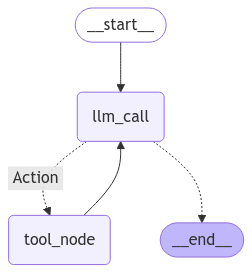

In [86]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [87]:
messages = [HumanMessage(content="Add 3 and 4. Then, take the output and multiple by 4.")]
messages = graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Then, take the output and multiple by 4.
================================== Ai Message ==================================

[{'text': "I'll help you with that calculation. Let's break it down into steps:\n\n1. First, let's add 3 and 4:", 'type': 'text'}, {'id': 'toolu_01E6wfpfTvQejx3qQNCZxBFa', 'input': {'a': 3, 'b': 4}, 'name': 'add', 'type': 'tool_use'}]
Tool Calls:
  add (toolu_01E6wfpfTvQejx3qQNCZxBFa)
 Call ID: toolu_01E6wfpfTvQejx3qQNCZxBFa
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

[{'text': "2. Now, let's multiply the result (7) by 4:", 'type': 'text'}, {'id': 'toolu_01F3PBPmhZ11a5hrwATCQcCX', 'input': {'a': 7, 'b': 4}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls:
  multiply (toolu_01F3PBPmhZ11a5hrwATCQcCX)
 Call ID: toolu_01F3PBPm

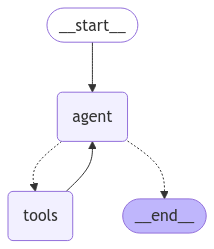

In [88]:
from langgraph.prebuilt import create_react_agent

new_agent = create_react_agent(llm_with_tools, tools)
display(Image(new_agent.get_graph(xray=True).draw_mermaid_png()))

In [89]:
messages = [HumanMessage(content="Add 3 and 4. Then, take the output and multiple by 4.")]
messages = new_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Then, take the output and multiple by 4.
================================== Ai Message ==================================

[{'text': "I'll help you with that! Let's break this down into two steps:\n\n1. First, let's add 3 and 4:", 'type': 'text'}, {'id': 'toolu_01Ae1SnxQ8qFizp8TWQb6FA3', 'input': {'a': 3, 'b': 4}, 'name': 'add', 'type': 'tool_use'}]
Tool Calls:
  add (toolu_01Ae1SnxQ8qFizp8TWQb6FA3)
 Call ID: toolu_01Ae1SnxQ8qFizp8TWQb6FA3
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

[{'text': "2. Now, let's multiply the result (7) by 4:", 'type': 'text'}, {'id': 'toolu_01GGVUwW4ctwFkUwEqxQ816u', 'input': {'a': 7, 'b': 4}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls:
  multiply (toolu_01GGVUwW4ctwFkUwEqxQ816u)
 Call ID: toolu_01GG

In [94]:
messages = [HumanMessage(content="Add 3 and 4")]

for msg, metadata in new_agent.stream({"messages": messages}, stream_mode="messages"):
    print(msg.content)

[]
[{'text': 'I', 'type': 'text', 'index': 0}]
[{'text': "'ll help you add 3 ", 'type': 'text', 'index': 0}]
[{'text': 'and 4 using the `', 'type': 'text', 'index': 0}]
[{'text': 'add` function.', 'type': 'text', 'index': 0}]
[{'id': 'toolu_01T7m57xSUtPhzfqEH7CoQzx', 'input': {}, 'name': 'add', 'type': 'tool_use', 'index': 1}]
[{'partial_json': '', 'type': 'tool_use', 'index': 1}]
[{'partial_json': '{"a', 'type': 'tool_use', 'index': 1}]
[{'partial_json': '": ', 'type': 'tool_use', 'index': 1}]
[{'partial_json': '3', 'type': 'tool_use', 'index': 1}]
[{'partial_json': ', ', 'type': 'tool_use', 'index': 1}]
[{'partial_json': '"b": 4}', 'type': 'tool_use', 'index': 1}]

7
[]
[{'text': '\n\nThe sum', 'type': 'text', 'index': 0}]
[{'text': ' of 3 and 4 is ', 'type': 'text', 'index': 0}]
[{'text': '7.', 'type': 'text', 'index': 0}]



In [93]:
msg.content

''